#### Goal :: Predict the sale (number of items) for the shop-item pair in the  test set. The test set is for one month - November 2015 

In [2]:
import numpy as np
import pandas as pd
import os
import matplotlib.pyplot as plt
%matplotlib inline

#### Read data

In [4]:
DATA_FOLDER = './'

transactions    = pd.read_csv(os.path.join(DATA_FOLDER, 'sales_train.csv.gz'))
items           = pd.read_csv(os.path.join(DATA_FOLDER, 'items.csv'))
item_categories = pd.read_csv(os.path.join(DATA_FOLDER, 'item_categories.csv'))
shops           = pd.read_csv(os.path.join(DATA_FOLDER, 'shops.csv'))

test = pd.read_csv(os.path.join(DATA_FOLDER, 'test.csv.gz'))


print(transactions.shape)
print(transactions.head(3))
print("\n--------------------------------------------------------\n")

print(test.shape)
print(test.head(3))
print("\n--------------------------------------------------------\n")


print(items.shape)
print(items.head(3))
print("\n--------------------------------------------------------\n")

print(item_categories.shape)
print(item_categories.head(3))
print("\n--------------------------------------------------------\n")

print(shops.shape)
print(shops.head(3))

print("\n--------------------------------------------------------\n")
print("Unique items: {}".format(len(set(items.item_id))))

print("\n--------------------------------------------------------\n")
print("Unique Categories: {}".format(len(set(item_categories.item_category_id))))

# YOUR CODE GOES HERE

print(transactions.shape)
print(transactions.head(3))
print("\n--------------------------------------------------------\n")

print(items.shape)
print(items.head(3))
print("\n--------------------------------------------------------\n")

print(item_categories.shape)
print(item_categories.head(3))
print("\n--------------------------------------------------------\n")

print(shops.shape)
print(shops.head(3))


print("\n--------------------------------------------------------\n")
print("Unique items: {}".format(items.item_id.nunique()))

print("\n--------------------------------------------------------\n")
print("Unique Categories: {}".format(item_categories.item_category_id.nunique()))

print("\n--------------------------------------------------------\n")
print("Unique Shops: {}".format(shops.shop_id.nunique()))


(2935849, 6)
         date  date_block_num  shop_id  item_id  item_price  item_cnt_day
0  02.01.2013               0       59    22154       999.0           1.0
1  03.01.2013               0       25     2552       899.0           1.0
2  05.01.2013               0       25     2552       899.0          -1.0

--------------------------------------------------------

(214200, 3)
   ID  shop_id  item_id
0   0        5     5037
1   1        5     5320
2   2        5     5233

--------------------------------------------------------

(22170, 3)
                                           item_name  item_id  \
0          ! ВО ВЛАСТИ НАВАЖДЕНИЯ (ПЛАСТ.)         D        0   
1  !ABBYY FineReader 12 Professional Edition Full...        1   
2      ***В ЛУЧАХ СЛАВЫ   (UNV)                    D        2   

   item_category_id  
0                40  
1                76  
2                40  

--------------------------------------------------------

(84, 2)
        item_category_name  item_categ

In [8]:
print("# unique shops in training: {}".format(transactions.shop_id.nunique()))
print("# unique shops in test: {}".format(test.shop_id.nunique()))

print("\n--------------------------------------------------------\n")

print("# unique items in training: {}".format(transactions.item_id.nunique()))
print("# unique items in test: {}".format(test.item_id.nunique()))

# unique shops in training: 60
# unique shops in test: 42

--------------------------------------------------------

# unique items in training: 21807
# unique items in test: 5100


In the training set, there are 60 unique shops and 21807 unique items.
In the test set, there are only 42 unique shops and 5100 unique items.
Maybe, we should get rid of the rows which contain the extra shops

(array([ 1667514.,   596397.,   255516.,   149577.,    65694.,   109883.,
           30281.,    17166.,     5341.,     4649.]),
 array([ -1.00000000e+00,   4.99024000e+02,   9.99048000e+02,
          1.49907200e+03,   1.99909600e+03,   2.49912000e+03,
          2.99914400e+03,   3.49916800e+03,   3.99919200e+03,
          4.49921600e+03,   4.99924000e+03]),
 <a list of 10 Patch objects>)

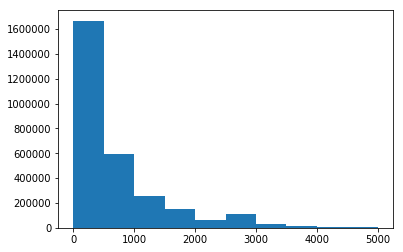

In [21]:
#plt.hist(transactions.item_price)

plt.hist(transactions[transactions.item_price < 5000].item_price)